<a href="https://colab.research.google.com/github/ludigoncalves/bemol-challenge/blob/master/eda_e_segmentacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visão Geral

Para este desafio, estou considerando a base de dados [Online Retail](https://www.kaggle.com/hellbuoy/online-retail-customer-clustering) devido a natureza dos atributos que podem ser explorados no contexto da Bemol. Por exemplo, usando atributo de localidade (na base nós temos o atributo 'Country') podemos explorar estratégias de Marketing em uma granularidade menor, i.e. por regiões/bairros, ou em uma granularidade maior, como estados (devido a presença da rede Bemol em diversos estados). Outra caracteríística interessante dessa base é que ela possui informação sobre os items comprados pelos consumidores, o que pode ser usado, em termos de estratégia de Marketing novamente, para fazer recomendações de produtos comprados por consumidores pertencentes ao mesmo segmento (cluster) para um consumidor que não os comprou ainda.

A base de dados Online Retail contém transações que ocorrem dentro do período de 01/12/2010 à 09/12/2011 em 38 países diferentes. A companhia vende principalmente presentes exclusivos para todas as ocasições e muitos dos seus clientes são atacadistas. 

# Objetivo

O objetivo deste trabalho consiste em segmentar uma lista de clientes com base em suas transações. Para isto, será utilizada a técnica de análise conhecida como RFM (do inglês Recency, Frequency, and Monetary value). RFM é uma técnica comumente utilizada em Marketing que usa histórico de comportamento de compras para dividir os consumidores em grupos de acordo com as seguintes métricas:
  - Recency (R): tempo decorrido desde a última compra de um dado consumidor. São clientes mais suscetíveis a responder a novas ofertas.
  - Frequency (F): núúmero total de compras do consumidor. Clientes que compraram muito são mais suscetíveis a responder a ofertas que clientes que compraram pouco.
  - Monetary value (M): valor total gasto em compras. Clientes que gastaram valor considerável em compras no passado são mais passíveis de realizarem compras volumosas novamente.

Fontes:
1. [IBM](https://www.ibm.com/support/knowledgecenter/da/SSLVMB_23.0.0/spss/rfm/rfm_intro.xml.html)
2. [Blast Analytics](https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales)

# Metodologia

1. Leitura e Exploração dos Dados
2. Limpeza dos Dados
3. Preparação dos Dados
4. Segmentação
5. Análises

# Configurações

In [251]:
# Este código foi construído no ambiente de desenvolvimento https://colab.research.google.com/
# Utilizando ambiente Python 3.6.9
# Imports necessários para este desafio

from google.colab import drive # monta ambiente para salvar dados gerados no notebook
import os # seta o caminho no ambiente como padrão 

import pandas as pd # biblioteca para processamento dos dados
import numpy as np # biblioteca de algebra linear

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
# funcao mágica para manter os graficos no notebook e próximos ao código gerador
%matplotlib inline 

# Biblioteca para datas
import datetime

In [252]:
# E importante saber as versoes das bibliotecas para congelamento do ambiente (como em containers)
!python --version

Python 3.6.9


In [253]:
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Matplotlib: ", mpl.__version__)
print("Seaborn:", sns.__version__)

Pandas: 1.0.5
Numpy: 1.18.5
Matplotlib:  3.2.2
Seaborn: 0.10.1


In [254]:
# Monta o ambiente onde os dados gerados neste notebook serao salvos
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [255]:
# Seta o caminho onde os dados serao salvos
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Bemol_Challenge')

In [256]:
!pwd

/content/gdrive/My Drive/Colab Notebooks/Bemol_Challenge


# Carrega base de dados

In [257]:
# Carrega a base
online_retail = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/OnlineRetail.csv", sep=',', encoding="ISO-8859-1", header=0)

In [258]:
online_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [259]:
online_retail['Country'].nunique()

38

In [260]:
# Explora o numero de transacoes por pais
countries = online_retail.groupby(by='Country')['InvoiceNo'].count().to_frame().reset_index()
countries = countries.sort_values(by='InvoiceNo', ascending=False, ignore_index=True)
print(countries)

                 Country  InvoiceNo
0         United Kingdom     495478
1                Germany       9495
2                 France       8557
3                   EIRE       8196
4                  Spain       2533
5            Netherlands       2371
6                Belgium       2069
7            Switzerland       2002
8               Portugal       1519
9              Australia       1259
10                Norway       1086
11                 Italy        803
12       Channel Islands        758
13               Finland        695
14                Cyprus        622
15                Sweden        462
16           Unspecified        446
17               Austria        401
18               Denmark        389
19                 Japan        358
20                Poland        341
21                Israel        297
22                   USA        291
23             Hong Kong        288
24             Singapore        229
25               Iceland        182
26                Canada    

Esta base inicial possui 541909 transações e 8 atributos

In [261]:
online_retail.shape

(541909, 8)

Com o comando .info() conseguimos ver que alguns atributos possuem dados faltantes, como CustomerID, que precisarão ser tratados posteriomente

In [262]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Com o método .describe() conseguimos ver que nos atributos 'Quantity' e 'UnitPrice' temos valores menores que zero, o que configura em dado ruidoso e também precisa ser removido

In [263]:
online_retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Limpeza dos Dados

Para fazermos uma análise que possua um grande volume de dados e também possamos utilizar a visão de análise por regiões, somente os três países com maior número de transações serão utilizados

In [264]:
retail_uk = online_retail[online_retail['Country'] == 'United Kingdom'].copy() # o metodo .copy() garante que voce nao altere o dataframe original
print('United Kingdom: ', retail_uk.shape)

retail_ger = online_retail[online_retail['Country'] == 'Germany'].copy()
print('Germany: ', retail_ger.shape)

retail_fra = online_retail[online_retail['Country'] == 'France'].copy()
print('France: ', retail_fra.shape)

United Kingdom:  (495478, 8)
Germany:  (9495, 8)
France:  (8557, 8)


In [265]:
# Remocao de individuos com dados faltantes
retail_uk = retail_uk.dropna(subset=['CustomerID'], how='all')
print('United Kingdom: ', retail_uk.shape)

retail_ger = retail_ger.dropna(subset=['CustomerID'], how='all')
print('Germany: ', retail_ger.shape)

retail_fra = retail_fra.dropna(subset=['CustomerID'], how='all')
print('France: ', retail_fra.shape)

United Kingdom:  (361878, 8)
Germany:  (9495, 8)
France:  (8491, 8)


In [266]:
# Remocao de dados duplicados
retail_uk_copy = retail_uk.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep='first')
print('United Kingdom: ', retail_uk_copy.shape)

retail_ger_copy = retail_ger.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep='first')
print('Germany: ', retail_ger_copy.shape)

retail_fra_copy = retail_fra.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep='first')
print('France: ', retail_fra_copy.shape)

United Kingdom:  (19857, 8)
Germany:  (603, 8)
France:  (458, 8)


In [267]:
# Remoção de dados ruidosos em 'Quantity'
retail_uk_copy = retail_uk_copy[retail_uk_copy['Quantity'] > 0]
print('United Kingdom: ', retail_uk_copy.shape)

retail_ger_copy = retail_ger_copy[retail_ger_copy['Quantity'] > 0]
print('Germany: ', retail_ger_copy.shape)

retail_fra_copy = retail_fra_copy[retail_fra_copy['Quantity'] > 0]
print('France: ', retail_fra_copy.shape)

United Kingdom:  (16649, 8)
Germany:  (457, 8)
France:  (389, 8)


In [268]:
# Remoção de dados ruidosos em 'UnitPrice'
retail_uk_copy = retail_uk_copy[retail_uk_copy['UnitPrice'] > 0]
print('United Kingdom: ', retail_uk_copy.shape)

retail_ger_copy = retail_ger_copy[retail_ger_copy['UnitPrice'] > 0]
print('Germany: ', retail_ger_copy.shape)

retail_fra_copy = retail_fra_copy[retail_fra_copy['UnitPrice'] > 0]
print('France: ', retail_fra_copy.shape)

United Kingdom:  (16643, 8)
Germany:  (457, 8)
France:  (389, 8)


Avaliando os descritores de informação vemos que os dados estão adequados agora

In [269]:
retail_uk_copy.describe()

,Quantity,UnitPrice,CustomerID
count,16643.000000,16643.000000,16643.000000
mean,38.681368,5.319490,15507.853632
std,858.727526,75.567185,1626.228711
min,1.000000,0.040000,12346.000000
25%,3.000000,1.250000,14098.500000
50%,10.000000,2.080000,15498.000000
75%,24.000000,4.650000,16923.000000
max,80995.000000,8142.750000,18287.000000


In [270]:
retail_uk_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16643 entries, 0 to 541890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    16643 non-null  object 
 1   StockCode    16643 non-null  object 
 2   Description  16643 non-null  object 
 3   Quantity     16643 non-null  int64  
 4   InvoiceDate  16643 non-null  object 
 5   UnitPrice    16643 non-null  float64
 6   CustomerID   16643 non-null  float64
 7   Country      16643 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.1+ MB


Após os diversos tratamentos feitos nas bases dos 3 países selecionados para serem avaliados, observamos que os dados da França e da Alemanha ficaram muito insuficientes para serem bem analisados, assim, a partir deste ponto seguimos somente com os dados do Reino Unido.

In [271]:
retail_uk_copy['Date'] = pd.DatetimeIndex(retail_uk_copy['InvoiceDate']).date # cria coluna somente com a data formata (ignorando horario)
retail_uk_copy.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,2010-01-12
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom,2010-01-12
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom,2010-01-12
21,536368,22960,JAM MAKING SET WITH JARS,6,01-12-2010 08:34,4.25,13047.0,United Kingdom,2010-01-12
25,536369,21756,BATH BUILDING BLOCK WORD,3,01-12-2010 08:35,5.95,13047.0,United Kingdom,2010-01-12


In [272]:
# Verifica min e max de data para estruturar a janela adequada de tempo dos dados
print('Minimum data: ', retail_uk_copy['Date'].min())
print('Maximum data: ', retail_uk_copy['Date'].max())

Minimum data:  2010-01-12
Maximum data:  2011-12-10


Como normalmente utilizamos métricas de avaliações de vendas baseadas em anos ou meses, a base será restringida para contemplar exatamente 365 dias, dado que temos dados com menos de dois anos.

In [273]:
uk_df = retail_uk_copy[retail_uk_copy['Date'] > datetime.date(year=2010,month=12,day=9)]
print('United Kingdom: ', uk_df.shape)

United Kingdom:  (15859, 9)


In [274]:
# Verifica min e max de data para a nova janela de tempo dos dados
print('Minimum data: ', uk_df['Date'].min())
print('Maximum data: ', uk_df['Date'].max())

Minimum data:  2010-12-12
Maximum data:  2011-12-10


In [275]:
# Dados da base depois de pre-processdados
print("SUMMARY:")
print("# transactions:\t\t", uk_df['InvoiceNo'].nunique())
print("# products bought:\t", uk_df['StockCode'].nunique())
print("# customers:\t\t", uk_df['CustomerID'].nunique())

SUMMARY:
# transactions:		 15859
# products bought:	 2443
# customers:		 3849


# Preparação dos Dados para o RFM <br>

Como citado anteriormente, o método utilizado para realizar a segmentação dos clientes será o RFM, que consiste nas métricas 1) Recency (R), 2) Frequency (F) e 3) Monetary value (M), que serão calculadas e agrupadas a partir deste ponto.

* Recency (R) <br>
  Para calcular o recency precisamos pegar a data mais recente na base (data referência) e calcular o tempo decorrido (em dias) entre a última compra de cada consumidor e a nossa data referência.

In [276]:
# Data mais recente da base
ref_date = uk_df['Date'].max()
print("Data referência: ", ref_date)

Data referência:  2011-12-10


In [277]:
# Agrupa os consumidores e extrai a data mais recente de compra de cada um
recency_df = uk_df.groupby(by='CustomerID', as_index=False)['Date'].max()
recency_df.columns = ['CustomerID', 'LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12747.0,2011-11-17
2,12748.0,2011-12-05
3,12749.0,2011-11-17
4,12820.0,2011-10-26


In [278]:
# Modifica o tipo de dado para uma melhor visualização
recency_df['CustomerID'] = recency_df['CustomerID'].astype(int)

In [279]:
# Calcula a recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (ref_date - x).days)
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346,2011-01-18,326
1,12747,2011-11-17,23
2,12748,2011-12-05,5
3,12749,2011-11-17,23
4,12820,2011-10-26,45


In [280]:
# Apaga a coluna 'LastPurchaseDate' jáá que não será mais usada
recency_df = recency_df.drop('LastPurchaseDate', axis=1)
recency_df.head()

,CustomerID,Recency
0,12346,326
1,12747,23
2,12748,5
3,12749,23
4,12820,45


* Frequency (F) <br>
  A métrica frequency identifica o número de compras feitas por cada cliente. Esse valor pode ser obtido aqui através da quantidade de 'InvoiceNo' por cliente.

In [281]:
frequency_df = uk_df.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,186
3,12749.0,5
4,12820.0,4


In [282]:
# Modifica o tipo de dado para uma melhor visualização
frequency_df['CustomerID'] = frequency_df['CustomerID'].astype(int)

* Monetary value (M) <br>
  Consiste no montante total gasto pelo cliente. Ela será obtida através da soma do montante gerado por cada compra.

In [283]:
# Cria coluna com o montante por compra
uk_df['Amount'] = uk_df['Quantity'] * uk_df['UnitPrice'].values
uk_df.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Amount
541863,581582,23552,BICYCLE PUNCTURE REPAIR KIT,6,09-12-2011 12:21,2.08,17581.0,United Kingdom,2011-09-12,12.48
541865,581583,20725,LUNCH BAG RED RETROSPOT,40,09-12-2011 12:23,1.45,13777.0,United Kingdom,2011-09-12,58.00
541867,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,72,09-12-2011 12:25,0.72,13777.0,United Kingdom,2011-09-12,51.84
541869,581585,22481,BLACK TEA TOWEL CLASSIC DESIGN,12,09-12-2011 12:31,0.39,15804.0,United Kingdom,2011-09-12,4.68
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,09-12-2011 12:49,2.95,13113.0,United Kingdom,2011-09-12,23.60


In [284]:
monetary_df = uk_df.groupby(by=['CustomerID'], as_index=False)['Amount'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3499.03
3,12749.0,98.35
4,12820.0,58.20


In [285]:
# Verifica se as informacoes estao corretas
uk_df[uk_df['CustomerID'] == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Amount
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,18-01-2011 10:01,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [286]:
uk_df[uk_df['CustomerID'] == 12820.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Amount
59368,541283,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,17-01-2011 12:34,0.55,12820.0,United Kingdom,2011-01-17,13.2
360567,568236,23328,SET 6 SCHOOL MILK BOTTLES IN CRATE,4,26-09-2011 11:49,3.75,12820.0,United Kingdom,2011-09-26,15.0
420111,572873,23436,VINTAGE CHRISTMAS GIFT BAG LARGE,12,26-10-2011 13:27,1.25,12820.0,United Kingdom,2011-10-26,15.0
531846,580973,21098,CHRISTMAS TOILET ROLL,12,06-12-2011 15:12,1.25,12820.0,United Kingdom,2011-06-12,15.0


In [287]:
# Modifica o tipo de dado para uma melhor visualização
frequency_df['CustomerID'] = frequency_df['CustomerID'].astype(int)

* Concatena as tabelas das métricas individuais

In [288]:
# Concatena recency e frequency em uma tabela temporaria
temp_df = recency_df.merge(frequency_df, on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346,326,1
1,12747,23,10
2,12748,5,186
3,12749,23,5
4,12820,45,4


In [289]:
# Concatena a tabela temporaria anterior com a monetary
rfm_df = temp_df.merge(monetary_df, on='CustomerID')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,23,10,658.89
2,12748,5,186,3499.03
3,12749,23,5,98.35
4,12820,45,4,58.20


In [290]:
# Verificacao da corretude das informacoes
uk_df[uk_df['CustomerID'] == 12749.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Amount
184487,552694,22768,FAMILY PHOTO FRAME CORNICE,2,10-05-2011 15:25,9.95,12749.0,United Kingdom,2011-10-05,19.90
285802,561926,22969,HOMEMADE JAM SCENTED CANDLES,12,01-08-2011 12:48,1.45,12749.0,United Kingdom,2011-01-08,17.40
285887,561928,23245,SET OF 3 REGENCY CAKE TINS,6,01-08-2011 12:50,4.95,12749.0,United Kingdom,2011-01-08,29.70
476296,577009,22720,SET OF 3 CAKE TINS PANTRY DESIGN,3,17-11-2011 12:05,4.95,12749.0,United Kingdom,2011-11-17,14.85
529701,580750,23583,LUNCH BAG PAISLEY PARK,10,06-12-2011 09:56,1.65,12749.0,United Kingdom,2011-06-12,16.50


In [291]:
print("Amount sum: ", uk_df[uk_df['CustomerID'] == 12749.0]['Amount'].sum())
print("Diff days: ", (ref_date - datetime.date(2011,11,17)).days)

Amount sum:  98.35
Diff days:  23


## Avaliação e Remoção de *Outliers* <br>

Antes de realizar a segmentação (próxima etapa), precisa ser feita uma análise acerca de *outliers*, pois são dados que comprometem a acurácia das estimativas de segmentos, principalmente se houver uso de modelos de aprendizagem de máquina. A técnica de remoção de outliers utilizada será a conhecida regra estatística: <br>
  - $low\_outliers < Q1 - 1.5 * IQR$
  - $high\_outliers > Q3 + 1.5 * IQR$, onde $Q1$ e $Q3$ correspondem, respectivamente ao primeiro e terceiro quartile e o $IQR$ à métrica de dispersão *Interquartile Range*.

Text(0.5, 0, 'Attributes')

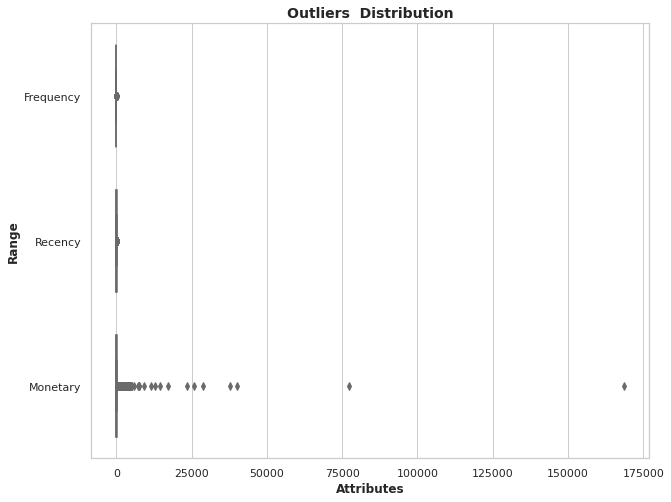

In [292]:
# Analise de outliers para Recency, Frequency e Monetary

attributes = ['Frequency','Recency', 'Monetary']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data=rfm_df[attributes], orient="h",palette="Set3" , whis=1.0, saturation=1, width=0.7)
plt.title("Outliers  Distribution", fontsize = 14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')

Como podemos observar no gráfico acima (um box-and-plot, ideal para visualização de *outliers*), há presença de *outliers* na nossa base.

In [293]:
# Cria tabela com remocao de outliers para analises posteriores com com e sem remocao
rfm_df_no_outlier = rfm_df.copy()
rfm_df_w_outlier = rfm_df.copy()

In [294]:
# Remove outliers em Recency
Q1 = rfm_df_no_outlier['Recency'].quantile(0.25) # primeiro quartile (25%)
Q3 = rfm_df_no_outlier['Recency'].quantile(0.75) # terceiro quartile (75%)

IQR = Q3 - Q1 # calcula interquartile range

print("Before outlier removing: ", rfm_df_no_outlier.shape)
rfm_df_no_outlier = rfm_df_no_outlier[(rfm_df_no_outlier['Recency'] >= Q1 - 1.5 * IQR) & (rfm_df_no_outlier['Recency'] <= Q3 + 1.5 * IQR)]
print("After outlier removing: ", rfm_df_no_outlier.shape)

Before outlier removing:  (3849, 4)
After outlier removing:  (3816, 4)


In [295]:
# Remove outliers em Frequency
Q1 = rfm_df_no_outlier['Frequency'].quantile(0.25) # primeiro quartile (25%)
Q3 = rfm_df_no_outlier['Frequency'].quantile(0.75) # terceiro quartile (75%)

IQR = Q3 - Q1 # calcula interquartile range

print("Before outlier removing: ", rfm_df_no_outlier.shape)
rfm_df_no_outlier = rfm_df_no_outlier[(rfm_df_no_outlier['Frequency'] >= Q1 - 1.5 * IQR) & (rfm_df_no_outlier['Frequency'] <= Q3 + 1.5 * IQR)]
print("After outlier removing: ", rfm_df_no_outlier.shape)

Before outlier removing:  (3816, 4)
After outlier removing:  (3585, 4)


In [296]:
# Remove outliers em Monetary
Q1 = rfm_df_no_outlier['Monetary'].quantile(0.25) # primeiro quartile (25%)
Q3 = rfm_df_no_outlier['Monetary'].quantile(0.75) # terceiro quartile (75%)

IQR = Q3 - Q1 # calcula interquartile range

print("Before outlier removing: ", rfm_df_no_outlier.shape)
rfm_df_no_outlier = rfm_df_no_outlier[(rfm_df_no_outlier['Monetary'] >= Q1 - 1.5 * IQR) & (rfm_df_no_outlier['Monetary'] <= Q3 + 1.5 * IQR)]
print("After outlier removing: ", rfm_df_no_outlier.shape)

Before outlier removing:  (3585, 4)
After outlier removing:  (3234, 4)


Text(0.5, 0, 'Attributes')

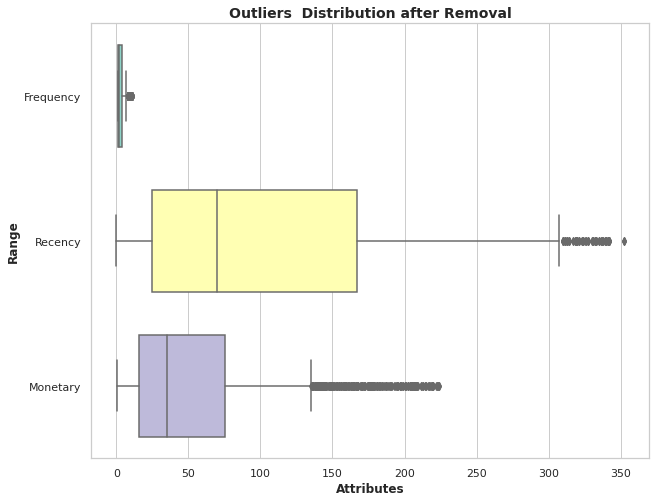

In [297]:
# Analise de outliers para Recency, Frequency e Monetary depois da remocao

attributes = ['Frequency','Recency', 'Monetary']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data=rfm_df_no_outlier[attributes], orient="h",palette="Set3" , whis=1.0, saturation=1, width=0.7)
plt.title("Outliers  Distribution after Removal", fontsize = 14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')

# Segmentação de Clientes (Tabela RFM)
  Uma forma amplamente utilizada e simples de criar segmentos com RFM é usando a métrica estatística *quartile*. Notas de 1 a 4 (se o valor está no primeiro quartile, no segundo, terceiro ou quarto) são associadas a Recency, Frequency e Monetary. Um consiste no melhor valor e 4 no pior. O segmento final é calculado combinando as três notas individuais atribuídas a cada métrica (i.e. '111' é um segmento).

## RFM Quartiles


In [298]:
# Encontra Q1, Q2 e Q3 para a tabela rfm
quartiles_no_outlier = rfm_df_no_outlier.quantile(q=[0.25, 0.50, 0.75])
quartiles_w_outlier = rfm_df_w_outlier.quantile(q=[0.25, 0.50, 0.75])
print(quartiles_no_outlier)

      CustomerID  Recency  Frequency  Monetary
0.25    14223.25     25.0        1.0   15.5625
0.50    15550.50     70.0        2.0   35.1000
0.75    16891.75    167.0        4.0   75.3725


In [299]:
# Para facilitar o acesso
quartiles_no_outlier.to_dict()
quartiles_w_outlier.to_dict()

{'CustomerID': {0.25: 14199.0, 0.5: 15556.0, 0.75: 16912.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 4.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.19999999999999},
 'Recency': {0.25: 22.0, 0.5: 60.0, 0.75: 154.0}}

## Criação dos Segmentos <br>
  Devido ao fato de em Recency um bom valor ser um valor baixo (quanto mais recente sua última compra tiver sido, menor é o valor) 
e o mesmo não valer para Frequency e Monetary (onde valores altos sãos os melhores valores), duas funções diferentes de criação de segmentos
precisam ser criadas.

In [300]:
# Funcoes para atribuicao de notas recency, frequency e monetary
def r_score(x, m, d):
  """ 
  Score Attribution Function
  Params:
    x = value,
    m = metric (recency)
    d = quartiles dictionary    
  """
  if x <= d[m][0.25]:
    return 1
  elif x <= d[m][0.50]:
    return 2
  elif x <= d[m][0.75]:
    return 3
  else:
    return 4

def fm_score(x, m, d):
  """ 
  Score Attribution Function
  Params:
    x = value,
    m = metric (frequency or monetary)
    d = quartiles dictionary    
  """
  if x <= d[m][0.25]:
    return 4
  elif x <= d[m][0.50]:
    return 3
  elif x <= d[m][0.75]:
    return 2
  else:
    return 1

In [301]:
# Cria tabela rfm com os segmentos para dados sem outliers

rfm_no_outlier = rfm_df_no_outlier.copy().set_index(['CustomerID'], drop=True)
rfm_no_outlier['R_Score'] = rfm_no_outlier['Recency'].apply(r_score, args=('Recency', quartiles_no_outlier,))
rfm_no_outlier['F_Score'] = rfm_no_outlier['Frequency'].apply(fm_score, args=('Frequency', quartiles_no_outlier,))
rfm_no_outlier['M_Score'] = rfm_no_outlier['Monetary'].apply(fm_score, args=('Monetary', quartiles_no_outlier,))

rfm_no_outlier.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerID,,,,,,
12749,23,5,98.35,1,1,1
12820,45,4,58.20,2,2,2
12821,96,1,19.92,3,4,3
12822,71,2,30.80,3,3,3
12824,30,1,5.04,2,4,4


In [302]:
# Com as notas calculadas, os segmentos sao montados, combinando R_Score, F_Score e M_Score para a tabela sem outliers
rfm_no_outlier['RFM'] = rfm_no_outlier['R_Score'].map(str) \
                + rfm_no_outlier['F_Score'].map(str) \
                + rfm_no_outlier['M_Score'].map(str)
rfm_no_outlier.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM
CustomerID,,,,,,,
12749,23,5,98.35,1,1,1,111
12820,45,4,58.20,2,2,2,222
12821,96,1,19.92,3,4,3,343
12822,71,2,30.80,3,3,3,333
12824,30,1,5.04,2,4,4,244


## Salva a Tabela RFM para consumo

In [ ]:
# Salva tabela final sem outliers
rfm_no_outlier.to_csv('rfm_table_no_outlier.csv')

# Salva tabela final com outliers
rfm_w_outlier.to_csv('rfm_table_w_outlier.csv')

# Análises

In [303]:
rfm_no_outlier.shape

(3234, 7)

Segundo a fonte [Blast Analytics](https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales), a tabela a seguir apresenta os principais segmentos RFM e sugestões de atuação em nível de Marketing.

| Segmentos | RFM | Descrição | Ações de Marketing |
|-----------|-----|-----------|--------------------|
| Melhores Clientes | 111 | Comprou mais recentemente, <br> com mais frequência e gastou mais | Sem incentivo de preços, novos produtos <br> e programas de lealdade |
| Clientes Leais | x1x | Compra frequentemente | Usa R e M pra repensar estratégias |
| Grandes Compradores | xx1 | Gastam mais | Mostrar itens mais caros |
| Quase perdido | 311 | Não compra há algum tempo, <br> mas comprou com frequencia e <br> gastou muito | Incentivo com preços agressivos |
| Cliente perdido | 411 |  Não compra há muito tempo, <br> mas comprou com frequencia e <br> gastou muito | Incentivo com preçços agressivos |
| Clientes baratos perdidos | 444 | Comprou há muito tempo, <br>pouco e gastou pouco também | Não perca muito tempo tentando readquiri-lo |

Com base nesta tabela, criaremos uma coluna 'Segment' para a realização de algumas análises. Mais segmentos podem ser análisados dependendo da necessidade da equipe de Marketing.


In [304]:
# Extraindo lista de clientes contidos nos segmentos melhores clientes, quase perdido, cliente perdido e clientes baratos perdidos
best = rfm_no_outlier.loc[rfm_no_outlier['RFM'] == '111'].index
almost_lost = rfm_no_outlier.loc[rfm_no_outlier['RFM'] == '311'].index
lost = rfm_no_outlier.loc[rfm_no_outlier['RFM'] == '411'].index
lost_cheap = rfm_no_outlier.loc[rfm_no_outlier['RFM'] == '444'].index

In [305]:
# Atribuindo os segmentos a tabela rfm
rfm_no_outlier['Segment'] = np.array([np.nan for i in range(rfm_no_outlier.shape[0])])

rfm_no_outlier.loc[rfm_no_outlier.index.isin(best), 'Segment'] = "Melhores Clientes"
rfm_no_outlier.loc[rfm_no_outlier.index.isin(almost_lost), 'Segment'] = "Quase Perdido"
rfm_no_outlier.loc[rfm_no_outlier.index.isin(lost), 'Segment'] = "Cliente Perdido"
rfm_no_outlier.loc[rfm_no_outlier.index.isin(lost_cheap), 'Segment'] = "Clientes Baratos Perdidos"

In [306]:
# Atribui segmento 'Loyal Customers' aos individuos com a melhor nota em frequency
loyal_temp = rfm_no_outlier.loc[rfm_no_outlier['F_Score'] == 1].index

# Filtra os clientes que ja apareceram em outros segmentos
loyal = loyal_temp[~loyal_temp.isin(best)]
loyal = loyal[~loyal.isin(almost_lost)]
loyal = loyal[~loyal.isin(lost)]

rfm_no_outlier.loc[rfm_no_outlier.index.isin(loyal), 'Segment'] = "Clientes Leais"


# Atribui segmento 'Big Spenders' aos individuos com a melhor nota em monetary
big_spenders_temp = rfm_no_outlier.loc[rfm_no_outlier['M_Score'] == 1].index

big_spenders = big_spenders_temp[~big_spenders_temp.isin(best)]
big_spenders = big_spenders[~big_spenders.isin(almost_lost)]
big_spenders = big_spenders[~big_spenders.isin(lost)]

rfm_no_outlier.loc[rfm_no_outlier.index.isin(big_spenders), 'Segment'] = "Grandes Compradores"

In [307]:
# Preenche quem ficou sem segmento
rfm_no_outlier['Segment'] = rfm_no_outlier['Segment'].fillna("Outros")

In [308]:
# Verificacao dos valores
rfm_no_outlier['Segment'].unique()

array(['Melhores Clientes', 'Outros', 'Grandes Compradores',
       'Quase Perdido', 'Clientes Baratos Perdidos', 'Clientes Leais',
       'Cliente Perdido'], dtype=object)

Com os principais segmentos definidos, podemos plotar alguns gráficos pra analisarmos a distribuição dos segmentos

In [309]:
# Construcao de ados de representacao de cada segmento
plot_data = rfm_no_outlier.groupby(by=['Segment'], as_index=False)['RFM'].count().rename(columns={'RFM': 'Count'})
plot_data = plot_data.sort_values(by='Count', ascending=False).reset_index(drop=True)
plot_data['Percentage'] = plot_data['Count'].apply(lambda x: x/rfm_no_outlier.shape[0])

In [310]:
# Construcao de dados de recency medio por segmento
plot_data_r = rfm_no_outlier.groupby(by=['Segment'], as_index=False)['Recency'].mean().rename(columns={'Recency': 'AVG_Recency'})
plot_data_r['AVG_Recency'] = plot_data_r['AVG_Recency'].round(2)
plot_data_r = plot_data_r.sort_values(by='AVG_Recency', ascending=False).reset_index(drop=True)

In [311]:
# Construcao de dados de frequency medio por segmento
plot_data_f = rfm_no_outlier.groupby(by=['Segment'], as_index=False)['Frequency'].mean().rename(columns={'Frequency': 'AVG_Frequency'})
plot_data_f['AVG_Frequency'] = plot_data_f['AVG_Frequency'].round(2)
plot_data_f = plot_data_f.sort_values(by='AVG_Frequency', ascending=False).reset_index(drop=True)

In [312]:
# Construcao de dados de monetary medio por segmento
plot_data_m = rfm_no_outlier.groupby(by=['Segment'], as_index=False)['Monetary'].mean().rename(columns={'Monetary': 'AVG_Monetary'})
plot_data_m['AVG_Monetary'] = plot_data_m['AVG_Monetary'].round(2)
plot_data_m = plot_data_m.sort_values(by='AVG_Monetary', ascending=False).reset_index(drop=True)

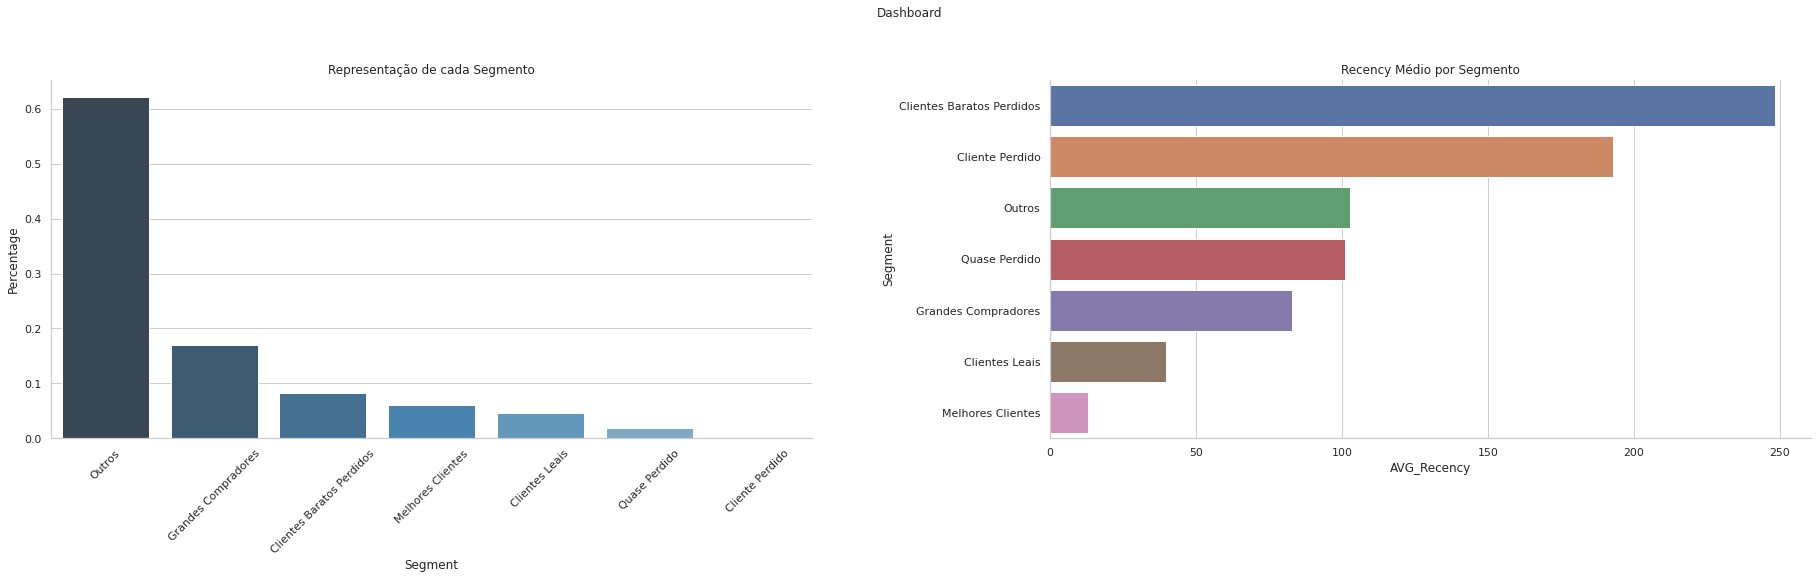

In [313]:
# Dashboard
fig = plt.figure(figsize=(27,9))

ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Representação de cada Segmento')
ax1.set_xticklabels(plot_data['Segment'], rotation=45)
sns.barplot(data=plot_data, x='Segment', y='Percentage', palette='Blues_d')

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Recency Médio por Segmento')
ax2.set_xlabel('Average Recency (days)')
ax2 = sns.barplot(data=plot_data_r, x='AVG_Recency', y='Segment')
#ax.set_title('Average Recency per Segment')

sns.despine()

fig.tight_layout(pad=7.0)                                                    
fig.suptitle('Dashboard')
plt.show()

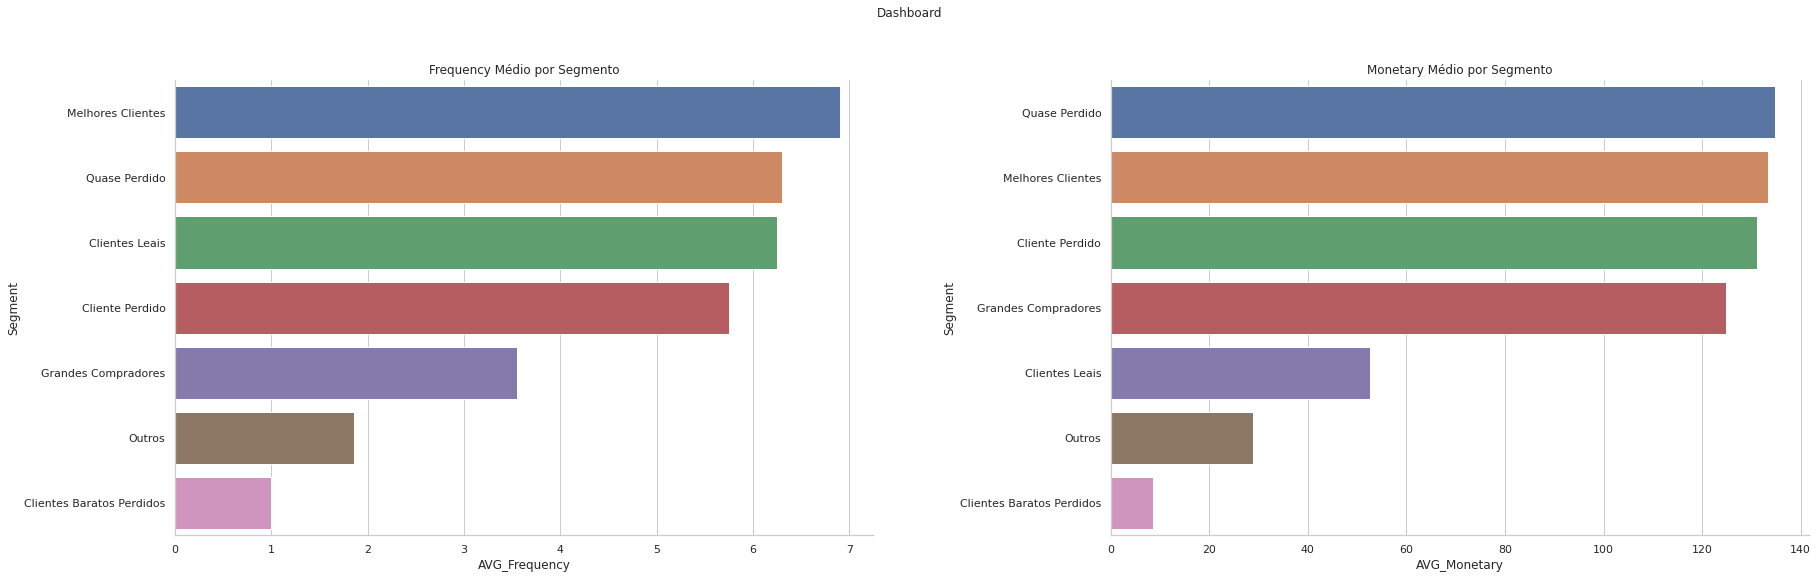

In [314]:
# Dashboard
fig = plt.figure(figsize=(27,9))

ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text('Frequency Médio por Segmento')
ax1.set_xlabel('Average Frequency')
ax1 = sns.barplot(data=plot_data_f, x='AVG_Frequency', y='Segment')

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Monetary Médio por Segmento')
ax2.set_xlabel('Average Monetary')
ax2 = sns.barplot(data=plot_data_m, x='AVG_Monetary', y='Segment')

sns.despine()

fig.tight_layout(pad=7.0)                                                    
fig.suptitle('Dashboard')
plt.show()

Observando os gráficos conseguimos obervar que: <br>
 1. Devido a grande quantidade de clientes fora das classes principais desenhadas pelos especialistas no geral, aqui representadas em 'Outros', se faz necessário encontrar outra abordagem para analisar este grupo, que por restrições de tempo não será explorado.
 2. Outro ponto interessante é que compradores leais, apesar da alta frequência de compra e também de serem compradores recentes, não gastam muito em suas compras. Um ponto que poderia ser analisado seria o perfil de compra desses compradores, como categoria de produtos (dado que se tem acesso a este dado) entre outros, que proporcione dados para ações de engajamento desses compradores em compras maiores.
 3. Um grupo que também me chamou atenção foi o de 'Quase Perdido'. Apesar de normalmente ser classificado como um grupo que não compra há algum tempo, ele não está entre os piores nessa classificação, mas se encontra nos top compradores mais frequentes e que mais gastam, demandando assim uma certa atenção por parte do Marketing, pois acredito que sejam clientes fáceis de voltar a cativar.